# Unsupervised Clustering of Pet Photos

### What am i doing in this notebook?

In this notebook, I will explore how I can give the computer a group of pet images, and it can cluster the ones with the same animals together.

I will be doing that by encoding the images through a trained convolutional network, and then apply a clustering algorithm to the encoded features. We can then check the clusters and see if it worked!

### Let's import the libraries we'll need

Keras is using a TensorFlow backend in our case here.

In [9]:

import time
import os, os.path
import random
import cv2
import glob
import keras
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np

## Dataset loading



In [10]:
import os
import pandas as pd

script_dir = os.path.dirname(os.path.abspath("capstone.py",))
os.chdir(script_dir)
# Directory where images are stored
DIR = "./wasteimage"

def dataset_stats():
    # List of subfolder names representing different types of waste
    waste_types = ['plant', 'food', 'paper']
    
    # Dictionary where we will store the stats
    stats = []
    
    for waste_type in waste_types:
        # Construct the path to the subdirectory
        sub_directory = os.path.join(DIR, waste_type)
        
        # Get list of file names in the subdirectory
        file_names = [file for file in os.listdir(sub_directory) if os.path.isfile(os.path.join(sub_directory, file))]
        file_count = len(file_names)
        sub_directory_name = os.path.basename(sub_directory)
        # Append stats to the list
        stats.append({ "Code": sub_directory_name[:],
                            "Image count": file_count, 
                           "Folder name": os.path.basename(sub_directory),
                            "File names": file_names})
    
    # Convert stats to a DataFrame
    df = pd.DataFrame(stats)
    
    return df

# Generate the dataset statistics
dataset = dataset_stats()
# Show codes with their folder names and image counts
dataset = dataset_stats().set_index("Code")
dataset[["Folder name", "Image count"]]


,Folder name,Image count
Code,,
plant,plant,323
food,food,411
paper,paper,500


### Loading the images

Now we create a function that loads all images in a directory for a given array of codes in one array and creates the corresponding label array for them.

Loaded images are resized to 224 x 224 before storing them in our array since this is the size preferred by VGG19 which we will be using later.

In [11]:
# Function returns an array of images whoose filenames start with a given set of characters
# after resizing them to 224 x 224

def load_images(codes):
    
    # Define empty arrays where we will store our images and labels
    images = []
    labels = []
    
    for code in codes:
        # get the folder name for this code
        folder_name = dataset.loc[code]["Folder name"]
        
        for file in dataset.loc[code]["File names"]:                 
            # build file path
            file_path = os.path.join(DIR, folder_name, file)
        
            # Read the image
            image = cv2.imread(file_path)

            # Resize it to 224 x 224
            image = cv2.resize(image, (224,224))

            # Convert it from BGR to RGB so we can plot them later (because openCV reads images as BGR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Now we add it to our array
            images.append(image)
            labels.append(code)

    return images, labels

In [12]:
codes = [ "paper","food", "plant"]
images, labels = load_images(codes)

### Randomly visualize images

Let's have a look at the breeds we loaded! The photos will not be in their original aspect ratio since we've resized them to fit what VGG needs

In [13]:
def show_random_images(images, labels, number_of_images_to_show=2):

    for code in list(set(labels)):

        indicies = [i for i, label in enumerate(labels) if label == code]
        random_indicies = [random.choice(indicies) for i in range(number_of_images_to_show)]
        figure, axis = plt.subplots(1, number_of_images_to_show)

        print("{} random images for code {}".format(number_of_images_to_show, code))

        for image in range(number_of_images_to_show):
            axis[image].imshow(images[random_indicies[image]])
        plt.show()

2 random images for code food


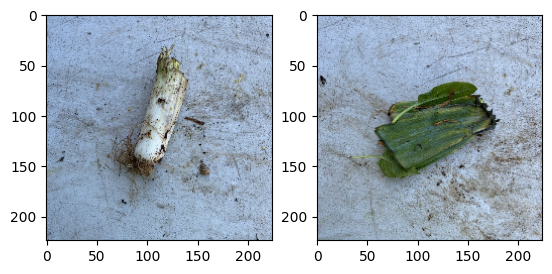

2 random images for code paper


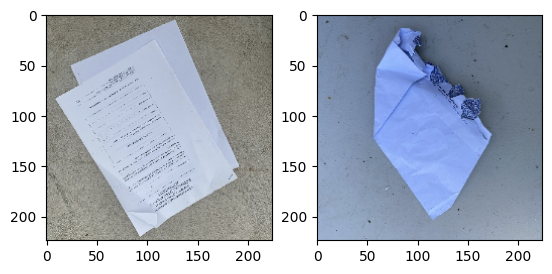

2 random images for code plant


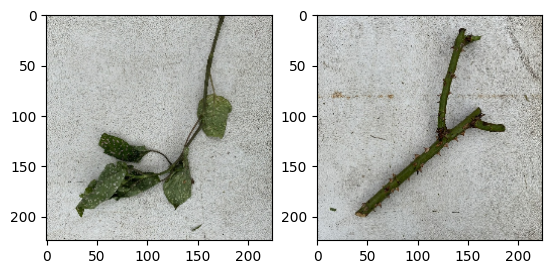

In [14]:
show_random_images(images, labels)

### Normalise (constrast enhancement)

We now convert the images and labels to NumPy arrays to make processing them easier. We then normalise the images before passing them on to VGG19

In [15]:
def normalise_images(images, labels):

    # Convert to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)

    # Normalise the images
    images /= 255
    
    return images, labels

In [16]:
images, labels = normalise_images(images, labels)

### Split dataset

Now that we have all the photos and their labels in arrays. It's time to shuffle them around, and split them to three different sets... training, validation and testing.

We'll be using the `train_test_split` function from sklearn which will also shuffle the data around for us, since it's currently in order.

In [17]:
def shuffle_data(images, labels):

    # Set aside the testing data. We won't touch these until the very end.
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=728)
    
    return X_train, y_train

In [18]:
X_train, y_train = shuffle_data(images, labels)

### Load pre-trained covnet models for FEATURE EXTRACTION
#### VGG16, VG19, ResNet50

We'll now load up the keras models with the imagenet weights. We'll remove the top dense layers, since we won't need to classify things here, and we just want these encoded features from the images.

In [19]:
# Load the models with ImageNet weights for extracting image features for futher tasks(like object detection or image classi)
#USED/RUN separately,INDEPENDENTLY for the same task
vgg16_model = keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3)) 

vgg19_model = keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(224,224,3)) #a variant of VGG16 with three additional convolutional layers.

resnet50_model = keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3)) #3 color channels RGB




### feature extraction=> feature arrays


The covnet models will give us 3D vectors that represent the image. We need to flatten these for the clustering algorithms to start working with them.

In [20]:
def covnet_transform(covnet_model, raw_images):

    # Pass raw images => a set of feature maps (3d array) detected by the models
    pred = covnet_model.predict(raw_images)

    # Flatten the array 3D=>2D
    flat = pred.reshape(raw_images.shape[0], -1)
    #(100, 7, 7, 512) representing 100 images, each with 7x7 feature maps of depth 512
    # => (100, 25088), where each row represents an image and each column represents a feature
    return flat


In [21]:
vgg16_output = covnet_transform(vgg16_model, X_train)
print("VGG16 flattened output has {} features".format(vgg16_output.shape[1]))

vgg19_output = covnet_transform(vgg19_model, X_train)
print("VGG19 flattened output has {} features".format(vgg19_output.shape[1]))

resnet50_output = covnet_transform(resnet50_model, X_train)
print("ResNet50 flattened output has {} features".format(resnet50_output.shape[1]))

31/31 ━━━━━━━━━━━━━━━━━━━━ 212s 7s/step
VGG16 flattened output has 25088 features
31/31 ━━━━━━━━━━━━━━━━━━━━ 188s 6s/step
VGG19 flattened output has 25088 features
31/31 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step
ResNet50 flattened output has 100352 features


The above cell shows us the number of features each covnet gives to a single image. When we compare these to the original size of the image 224 x 224 x 3 = 150,528 pixels/features, we can see that this is a large reduction in what the clustering algorithms will have to work with.

CNNs are designed to gradually reduce the spatial dimensions (width and height) of the input through their layers while increasing the depth (number of feature maps). The idea is to capture the high-level features (like shapes, textures, or even whole objects) in the deeper layers of the network=> features can be reduced that much

Hopefully these reduces number of feature are represent more meaningful features in the image structure.

### PCA(dimensionality reduction)

In [22]:
# Function that creates a PCA instance, fits it to the data and returns the instance
def create_fit_PCA(data, n_components=None):
    
    p = PCA(n_components=n_components, random_state=728)
    p.fit(data)
    
    return p
    

In [23]:
# Create PCA instances for each covnet output
vgg16_pca = create_fit_PCA(vgg16_output)
vgg19_pca = create_fit_PCA(vgg19_output)
resnet50_pca = create_fit_PCA(resnet50_output)


In [24]:
# Function to plot the cumulative explained variance of PCA components
# This will help us decide how many components we should reduce our features to
def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

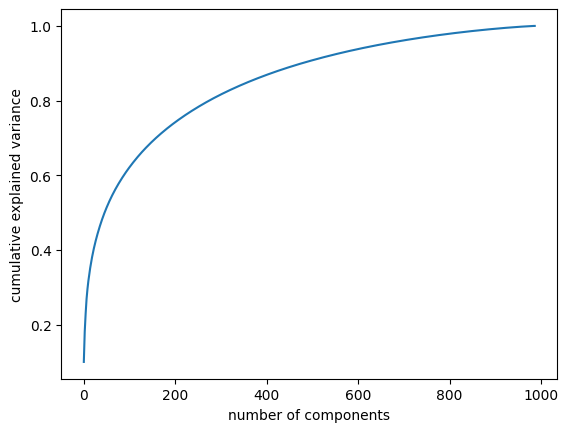

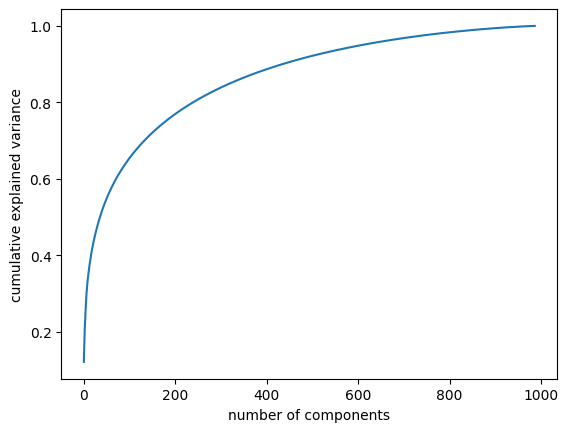

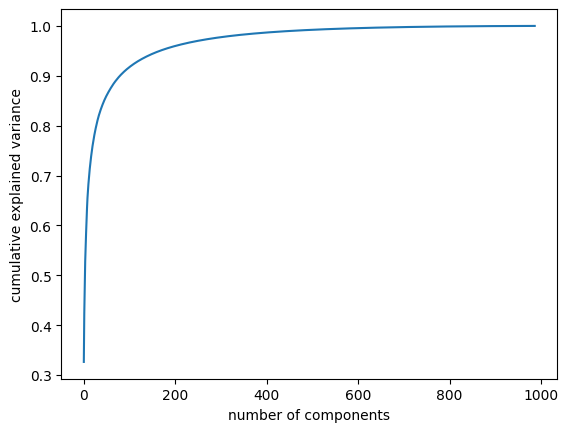

In [25]:
# Plot the cumulative explained variance for each covnet
pca_cumsum_plot(vgg16_pca)
pca_cumsum_plot(vgg19_pca)
pca_cumsum_plot(resnet50_pca)

Looking at the gaphs above, we can see that PCA can explain almost all the variance in as many dimensions as there are samples.

It is also interesting to note the difference in shape between the VGG graphs and the ResNet one. This is probably due to the fact that ResNet only had 2048 dimensions to start with, while VGGs had 25,088

In [26]:
# PCA transformations of covnet outputs
vgg16_output_pca = vgg16_pca.transform(vgg16_output)
vgg19_output_pca = vgg19_pca.transform(vgg19_output)
resnet50_output_pca = resnet50_pca.transform(resnet50_output)

### APPLY CLUSTERING ON EACH FEATURE EXTRATOR MODELS



In [27]:
def create_train_kmeans(data, number_of_clusters=len(codes)):
    
    k = KMeans(n_clusters=number_of_clusters, random_state=728)

    # Let's do some timings to see how long it takes to train.
    start = time.time()

    # Train it up
    k.fit(data)

    # Stop the timing 
    end = time.time()

    # And see how long that took
    print("Training took {} seconds".format(end-start))
    
    return k

In [28]:
# Let's pass the data into the algorithm and predict who lies in which cluster. 
# Since we're using the same data that we trained it on, this should give us the training results.

# Here we create and fit a KMeans model with the PCA outputs
print("KMeans (PCA): \n")

print("VGG16")
K_vgg16_pca = create_train_kmeans(vgg16_output_pca)

print("\nVGG19")
K_vgg19_pca = create_train_kmeans(vgg19_output_pca)

print("\nResNet50")
K_resnet50_pca = create_train_kmeans(resnet50_output_pca)

KMeans (PCA): 

VGG16
Training took 0.4732682704925537 seconds

VGG19
Training took 0.054731130599975586 seconds

ResNet50
Training took 0.01564788818359375 seconds


In [29]:
# Let's also create models for the covnet outputs without PCA for comparison
print("KMeans: \n")

print("VGG16:")
K_vgg16 = create_train_kmeans(vgg16_output)

print("\nVGG19:")
K_vgg19 = create_train_kmeans(vgg19_output)

print("\nResNet50:")
K_resnet50 = create_train_kmeans(resnet50_output)


KMeans: 

VGG16:
Training took 0.7670161724090576 seconds

VGG19:
Training took 0.5939154624938965 seconds

ResNet50:
Training took 2.348789930343628 seconds


In [30]:
# Now we get the cluster model predictions

# KMeans with PCA outputs
k_vgg16_pred_pca = K_vgg16_pca.predict(vgg16_output_pca)
k_vgg19_pred_pca = K_vgg19_pca.predict(vgg19_output_pca)
k_resnet50_pred_pca = K_resnet50_pca.predict(resnet50_output_pca)

# KMeans with CovNet outputs
k_vgg16_pred = K_vgg16.predict(vgg16_output)
k_vgg19_pred = K_vgg19.predict(vgg19_output)
k_resnet50_pred = K_resnet50.predict(resnet50_output)


Remember that the clustering algorith groups images that look alike together and assigns them a number arbitrarily. 

We now need to count how many of each label are in  each cluster, this way we can take a look and if sufficient eperation has happened we can quicly see which cluster is which label. So let's write a function that does that.

In [31]:
def cluster_label_count(clusters, labels):
    
    count = {}
    
    # Get unique clusters and labels
    unique_clusters = list(set(clusters))
    unique_labels = list(set(labels))
    
    # Create counter for each cluster/label combination and set it to 0
    for cluster in unique_clusters:
        count[cluster] = {}
        
        for label in unique_labels:
            count[cluster][label] = 0
    
    # Let's count
    for i in range(len(clusters)):
        count[clusters[i]][labels[i]] +=1
    
    cluster_df = pd.DataFrame(count)
    
    return cluster_df

In [32]:
# Cluster counting for VGG16 Means
vgg16_cluster_count = cluster_label_count(k_vgg16_pred, y_train)
vgg16_cluster_count_pca = cluster_label_count(k_vgg16_pred_pca, y_train)

# VGG19 KMeans
vgg19_cluster_count = cluster_label_count(k_vgg19_pred, y_train)
vgg19_cluster_count_pca = cluster_label_count(k_vgg19_pred_pca, y_train)

# ResNet50 KMeans
resnet_cluster_count = cluster_label_count(k_resnet50_pred, y_train)
resnet_cluster_count_pca = cluster_label_count(k_resnet50_pred_pca, y_train)



In [33]:
print("KMeans VGG16: ")
vgg16_cluster_count

KMeans VGG16: 


,0,1,2
food,0,152,182
paper,260,26,107
plant,0,251,9


In [34]:
print("KMeans VGG16 (PCA): ")
vgg16_cluster_count_pca

KMeans VGG16 (PCA): 


,0,1,2
food,0,152,182
paper,260,26,107
plant,0,251,9


In [35]:
print("KMeans VGG19: ")
vgg19_cluster_count

KMeans VGG19: 


,0,1,2
food,0,32,302
paper,202,172,19
plant,1,10,249


In [36]:
print("KMeans VGG19 (PCA): ")
vgg19_cluster_count_pca

KMeans VGG19 (PCA): 


,0,1,2
food,0,32,302
paper,202,172,19
plant,1,10,249


In [37]:
print("KMeans Resnet50: ")
resnet_cluster_count

KMeans Resnet50: 


,0,1,2
food,1,259,74
paper,62,194,137
plant,11,173,76


In [38]:
print("Kmeans Resnet50 (PCA): ")
resnet_cluster_count_pca

Kmeans Resnet50 (PCA): 


,0,1,2
food,1,259,74
paper,62,194,137
plant,11,173,76


We can see again, .... (models nào) could not produce meaningful clusters. therefore, We will therefore stop pursuing them.

The models that made it through are: (liệt kê ra)



Let's calculate some scores and see which one performs best.

### Cluster - Label assignment

In this part, we will manually look at the cluster count and give a best guess as to which cluster corresonds to which label. While normally each cluster will mostly consist of one label, it is not necessary the case if the clustering algorithm fails to seperate the images. It is therefore better to take stock here, and make sure that we are on the right path.

In [48]:
# Manually adjust these lists so that the index of each label reflects which cluster it lies in
vgg16_cluster_code = ["plant", "paper","food"]
vgg16_cluster_code_pca = ["plant", "paper","food"]

vgg19_cluster_code = ["plant", "paper","food"]
vgg19_cluster_code_pca = ["plant", "paper","food"]

resnet_cluster_code= ["plant", "paper","food"]



### Replace the predicted clusters with their labels

In [49]:
vgg16_pred_codes = [vgg16_cluster_code[x] for x in k_vgg16_pred]
vgg16_pred_codes_pca = [vgg16_cluster_code_pca[x] for x in k_vgg16_pred_pca]
vgg19_pred_codes = [vgg19_cluster_code[x] for x in k_vgg19_pred]
vgg19_pred_codes_pca = [vgg19_cluster_code_pca[x] for x in k_vgg19_pred_pca]
resnet_pred_code=[resnet_cluster_code[x] for x in k_resnet50_pred]

# g_vgg19_pred_codes_pca = [g_vgg19_cluster_code_pca[x] for x in g_vgg19_pred_pca]


### Metrics

Now that we have two arrays, one with the predicted labels and one with the true labels, we can go crazy with performance scores... or we can just compute the F1 score

In [50]:
from sklearn.metrics import accuracy_score, f1_score

def print_scores(true, pred):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average="macro")
    return "\n\tF1 Score: {0:0.8f}   |   Accuracy: {0:0.8f}".format(f1,acc)

print("KMeans VGG16:", print_scores(y_train, vgg16_pred_codes))
print("KMeans VGG16 (PCA)", print_scores(y_train, vgg16_pred_codes_pca))

print("\nKMeans VGG19: ", print_scores(y_train, vgg19_pred_codes))
print("KMeans VGG19 (PCA): ", print_scores(y_train, vgg19_pred_codes_pca))
print("KMeans Resnet: ", print_scores(y_train, resnet_pred_code))
# print("GMM VGG19 (PCA)", print_scores(y_train, g_vgg19_pred_codes_pca))


KMeans VGG16: 
	F1 Score: 0.21306990   |   Accuracy: 0.21306990
KMeans VGG16 (PCA) 
	F1 Score: 0.21306990   |   Accuracy: 0.21306990

KMeans VGG19:  
	F1 Score: 0.41306094   |   Accuracy: 0.41306094
KMeans VGG19 (PCA):  
	F1 Score: 0.41306094   |   Accuracy: 0.41306094
KMeans Resnet:  
	F1 Score: 0.22831967   |   Accuracy: 0.22831967


### of note:

1. The scores (and cluster counts) of PCA and non-PCA transformed outputs are exactly the same. Since we fixed all random states, with the only difference being the inputs, we can see that PCA-transformed data adequately represents the original data while givig us faster training times and lower memory usage.

2. The clusters for PCA and non-PCA transformed data are exactly in the same order.

### Testing Time

We can now then do the same thing for our testing data, and see if it gives the best accuracy again. We can keep testing this for more and more breed pairs to gain more confidence that our model works.

This is in the end an unsupevised learning excercise, and we would not be able to check which model is best for a particular set of data if we do not have labels for them. The closer your images are to the dataset images, the better chance you have of getting a high accuracy.

In [42]:
# Let's put it all together

def all_covnet_transform(data):
    vgg16 = covnet_transform(vgg16_model, data)
    vgg19 = covnet_transform(vgg19_model, data)
    resnet50 = covnet_transform(resnet50_model, data)
    
    return vgg16, vgg19, resnet50


def image_load_to_cluster_count(codes):
    # Load images
    images, labels = load_images(codes)
    print(len(images), len(labels))
    show_random_images(images, labels)
    
    # Normalise images
    images, labels = normalise_images(images, labels)
    
    # Split data
    data, labels = shuffle_data(images, labels)
    
    # Get covnet outputs
    vgg16_output, vgg19_output, resnet50_output = all_covnet_transform(data)
    
    # Get PCA transformations
    vgg16_output_pca = create_fit_PCA(vgg16_output).transform(vgg16_output)
    vgg19_output_pca = create_fit_PCA(vgg19_output).transform(vgg19_output)
    resnet50_output_pca = create_fit_PCA(resnet50_output).transform(resnet50_output)
    
    # Cluster
    clusters = len(codes)
    
    K_vgg16_pred = create_train_kmeans(vgg16_output, clusters).predict(vgg16_output)
    K_vgg19_pred = create_train_kmeans(vgg19_output, clusters).predict(vgg19_output)
    K_resnet50_pred = create_train_kmeans(resnet50_output, clusters).predict(resnet50_output)
    K_vgg16_pred_pca = create_train_kmeans(vgg16_output_pca, clusters).predict(vgg16_output_pca)
    K_vgg19_pred_pca = create_train_kmeans(vgg19_output_pca, clusters).predict(vgg19_output_pca)
    K_resnet50_pred_pca = create_train_kmeans(resnet50_output_pca, clusters).predict(resnet50_output_pca)
    
    # Count
    vgg16_cluster_count = cluster_label_count(K_vgg16_pred, labels)
    vgg16_cluster_count_pca = cluster_label_count(K_vgg16_pred_pca, labels)

    # VGG19 KMeans
    vgg19_cluster_count = cluster_label_count(K_vgg19_pred, labels)
    vgg19_cluster_count_pca = cluster_label_count(K_vgg19_pred_pca, labels)

    # ResNet50 KMeans
    resnet_cluster_count = cluster_label_count(K_resnet50_pred, labels)
    resnet_cluster_count_pca = cluster_label_count(K_resnet50_pred_pca, labels)
    
    print("KMeans VGG16: ")
    print(vgg16_cluster_count)
    print("\nKMeans VGG16 (PCA): ")
    print(vgg16_cluster_count_pca)
    print("\nKMeans VGG19: ")
    print(vgg19_cluster_count)
    print("\nKMeans VGG19 (PCA): ")
    print(vgg19_cluster_count_pca)
    print("KMeans Resnet50: ")
    print(resnet_cluster_count)
    print("Kmeans Resnet50 (PCA): ")
    print(resnet_cluster_count_pca)
    
    return  K_vgg16_pred, K_vgg16_pred_pca, K_vgg19_pred, K_vgg19_pred_pca, images, labels
    
    

1234 1234
2 random images for code food


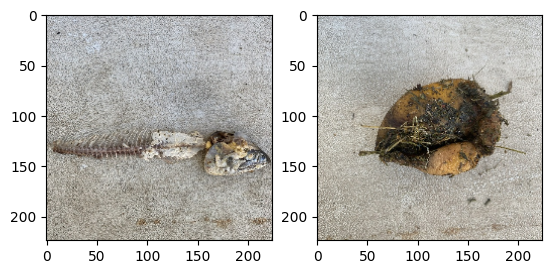

2 random images for code paper


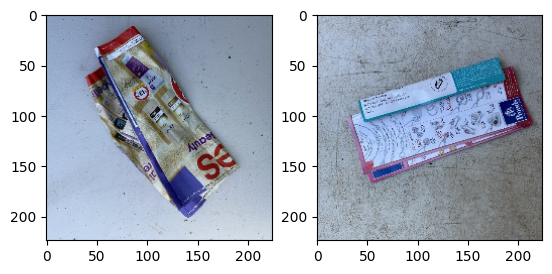

2 random images for code plant


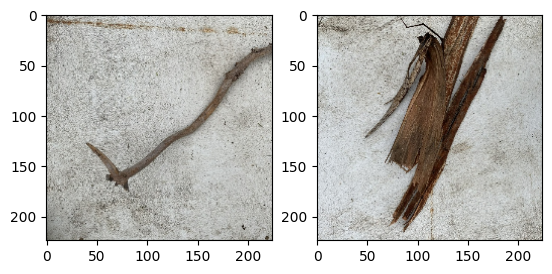

31/31 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step
Training took 1.0276293754577637 seconds
Training took 0.811830997467041 seconds
Training took 3.5249056816101074 seconds
Training took 0.034137725830078125 seconds
Training took 0.04105973243713379 seconds
Training took 0.03436470031738281 seconds
KMeans VGG16: 
         0    1    2
food     0   98  234
paper  243  142   16
plant    0   84  170

KMeans VGG16 (PCA): 
         0    1    2
food     0   98  234
paper  243  142   16
plant    0   84  170

KMeans VGG19: 
         0    1    2
food     0  297   35
paper  197   23  181
plant    1  245    8

KMeans VGG19 (PCA): 
         0    1    2
food     0  297   35
paper  197   23  181
plant    1  245    8
KMeans Resnet50: 
        0    1    2
food    0  251   81
paper  53  190  158
plant  12  160   82
Kmeans Resnet50 (PCA): 
        0    1    2
food    0  251   81
paper  53  190  158
plant  12  160   82


In [43]:
codes = ["plant", "paper","food"]
outputs = image_load_to_cluster_count(codes)

In [ ]:
print(outputs[4])

In [54]:
# Manually adjust these lists so that the index of each label reflects which cluter it lies in
a=["plant", "paper", "food"]
vgg16_cluster_code = a
vgg16_cluster_code_pca = a

vgg19_cluster_code = a
vgg19_cluster_code_pca = a
g_vgg19_cluster_code_pca = a


vgg16_pred_codes = [vgg16_cluster_code[x] for x in outputs[0]]
vgg16_pred_codes_pca = [vgg16_cluster_code_pca[x] for x in outputs[1]]
vgg19_pred_codes = [vgg19_cluster_code[x] for x in outputs[2]]
vgg19_pred_codes_pca = [vgg19_cluster_code_pca[x] for x in outputs[3]]
g_vgg19_pred_codes_pca = [g_vgg19_cluster_code_pca[x] for x in outputs[4]]

print("KMeans VGG16:", print_scores(outputs[-1], vgg16_pred_codes))
print("KMeans VGG16 (PCA)", print_scores(outputs[-1], vgg16_pred_codes_pca))

print("\nKMeans VGG19: ", print_scores(outputs[-1], vgg19_pred_codes))
print("KMeans VGG19 (PCA): ", print_scores(outputs[-1], vgg19_pred_codes_pca))
print("GMM VGG19 (PCA)", print_scores(outputs[-1], g_vgg19_pred_codes_pca))


TypeError: only integer scalar arrays can be converted to a scalar index

Looks like VGG16 is doing the best again! Let's test one more time...

1234 1234
2 random images for code food


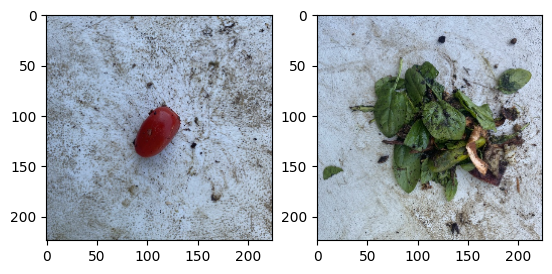

2 random images for code paper


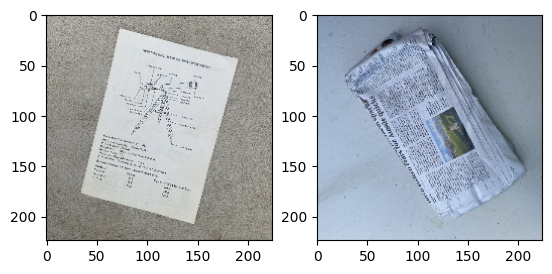

2 random images for code plant


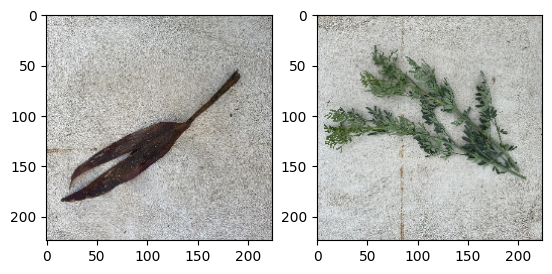

31/31 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step
Training took 1.4611856937408447 seconds
Training took 0.7560796737670898 seconds
Training took 3.292518138885498 seconds
Training took 0.03165864944458008 seconds
Training took 0.022439002990722656 seconds
Training took 0.015851497650146484 seconds
KMeans VGG16: 
         0    1    2
food     0   98  234
paper  243  142   16
plant    0   84  170

KMeans VGG16 (PCA): 
         0    1    2
food     0   98  234
paper  243  142   16
plant    0   84  170

KMeans VGG19: 
         0    1    2
food     0  297   35
paper  197   23  181
plant    1  245    8

KMeans VGG19 (PCA): 
         0    1    2
food     0  297   35
paper  197   23  181
plant    1  245    8
KMeans Resnet50: 
        0    1    2
food    0  251   81
paper  53  190  158
plant  12  160   82
Kmeans Resnet50 (PCA): 
        0    1    2
food    0  251   81
paper  53  190  158
plant  12  160   82


In [55]:
codes = ["plant", "paper","food"]
outputs = image_load_to_cluster_count(codes)

By now we can see that ResNet is performing terribly in all our tests. We can also see that PCA and non-PCA are the same, so we can just use the same cluster/code combinations for them, and that GMM has consistently performed same as or much worse than KMeans.

The two we will consider now are Kmeans VGG16 and VGG19

In [56]:
# Manually adjust these lists so that the index of each label reflects which cluter it lies in
vgg16_cluster_code = ["plant", "paper","food"]
vgg19_cluster_code = ["plant", "paper","food"]

In [ ]:
# Let's define a function for scores

def scoring(vgg16_cluster_code, vgg19_cluster_code, outputs):
    vgg16_pred_codes = [vgg16_cluster_code[x] for x in outputs[0]]
    vgg16_pred_codes_pca = [vgg16_cluster_code[x] for x in outputs[1]]
    vgg19_pred_codes = [vgg19_cluster_code[x] for x in outputs[2]]
    vgg19_pred_codes_pca = [vgg19_cluster_code[x] for x in outputs[3]]

    print("KMeans VGG16:", print_scores(outputs[-1], vgg16_pred_codes))
    print("KMeans VGG16 (PCA)", print_scores(outputs[-1], vgg16_pred_codes_pca))

    print("\nKMeans VGG19: ", print_scores(outputs[-1], vgg19_pred_codes))
    print("KMeans VGG19 (PCA): ", print_scores(outputs[-1], vgg19_pred_codes_pca))

In [ ]:
scoring(vgg16_cluster_code, vgg19_cluster_code, outputs)

KMeans VGG16: 
	F1 Score: 0.97500000   |   Accuracy: 0.97500000
KMeans VGG16 (PCA) 
	F1 Score: 0.97500000   |   Accuracy: 0.97500000

KMeans VGG19:  
	F1 Score: 0.93998650   |   Accuracy: 0.93998650
KMeans VGG19 (PCA):  
	F1 Score: 0.93998650   |   Accuracy: 0.93998650


VGG16 wins again!


400 400
2 random images for code D1


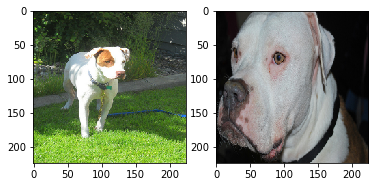

2 random images for code C7


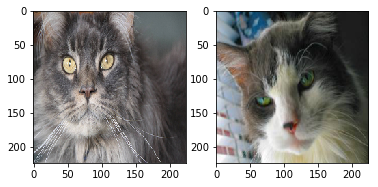

Training took 2.5923378467559814 seconds
Training took 2.034688711166382 seconds
Training took 0.4773135185241699 seconds
Training took 0.5953502655029297 seconds
Training took 0.565504789352417 seconds
Training took 0.4808497428894043 seconds
Training took 0.034923553466796875 seconds
Training took 0.024074554443359375 seconds
Training took 0.025286436080932617 seconds
KMeans VGG16: 
      0    1
C7  196    4
D1    5  195

KMeans VGG16 (PCA): 
      0    1
C7  196    4
D1    5  195

GMM VGG16: 
      0    1
C7    4  196
D1  195    5

KMeans VGG19: 
      0    1
C7   57  143
D1  200    0

KMeans VGG19 (PCA): 
      0    1
C7   57  143
D1  200    0
GMM VGG19 (PCA): 
     0    1
C7  15  185
D1  36  164
KMeans Resnet50: 
      0    1
C7   41  159
D1  116   84
Kmeans Resnet50 (PCA): 
      0    1
C7   41  159
D1  116   84
GMM Resnet50 (PCA): 
      0    1
C7   39  161
D1  111   89


In [ ]:
codes = ["plant", "paper","food"]
outputs = image_load_to_cluster_count(codes)

In [ ]:
vgg16_cluster_code = ["plant", "paper","food"]
vgg19_cluster_code = ["plant", "paper","food"]
scoring(vgg16_cluster_code, vgg19_cluster_code, outputs)

KMeans VGG16: 
	F1 Score: 0.97749986   |   Accuracy: 0.97749986
KMeans VGG16 (PCA) 
	F1 Score: 0.97749986   |   Accuracy: 0.97749986

KMeans VGG19:  
	F1 Score: 0.85454638   |   Accuracy: 0.85454638
KMeans VGG19 (PCA):  
	F1 Score: 0.85454638   |   Accuracy: 0.85454638
